In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/powergrid-assets-ml-dataset/Dataset_Full_Enriched.pkl


In [10]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvi

In [11]:
import sys
import io
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error




# Pasar de .pkl a .csv

In [12]:


# --- RUTA DEL ARCHIVO (Ya confirmada) ---
input_file = '/kaggle/input/powergrid-assets-ml-dataset/Dataset_Full_Enriched.pkl'
output_file = 'dataset_convertido.csv'

print(f"Versión de NumPy: {np.__version__}")

# --- EL TRUCO (MONKEY PATCHING) ---
# El archivo busca 'numpy._core', que es de NumPy 2.0.
# Si tienes una versión anterior (ej. 1.26), esto fallaría.
# Mapeamos manualmente el nombre nuevo al nombre viejo.

try:
    # Intentamos importar core, si no existe _core
    import numpy.core
    sys.modules['numpy._core'] = numpy.core
    from numpy import core
    sys.modules['numpy._core.numeric'] = core.numeric
    print("✅ Parche aplicado: 'numpy._core' redirigido a 'numpy.core'")
except Exception as e:
    print(f"⚠️ Nota sobre el parche: {e}")

# --- CARGA CON UNPICKLER PERSONALIZADO ---
# A veces pd.read_pickle es muy estricto. Usamos pickle directo.

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Si el archivo busca cosas raras de numpy 2.0, las desviamos
        if module == 'numpy._core.numeric':
            module = 'numpy.core.numeric'
        return super().find_class(module, name)

print(f"Leyendo {input_file} ...")

try:
    with open(input_file, 'rb') as f:
        # Intentamos primero la carga estándar con el parche de sys.modules
        data = pd.read_pickle(f)
    
    print("\n🎉 ¡ÉXITO! El archivo se abrió.")
    
    # --- INSPECCIÓN Y GUARDADO ---
    if isinstance(data, pd.DataFrame):
        print(f"Dimensiones: {data.shape}")
        print("Columnas:", list(data.columns[:5]), "...") # Mostrar primeras 5 columnas
        
        # Guardar a CSV
        output_path = f'/kaggle/working/{output_file}'
        data.to_csv(output_path, index=False)
        print(f"\n💾 Guardado en: {output_path}")
        
    else:
        print(f"El objeto cargado es: {type(data)}")

except Exception as e:
    print("\n❌ Falló el método 1. Intentando método alternativo (Compatibilidad Forzada)...")
    try:
        # Intento desesperado: Cargar solo los datos crudos ignorando funciones
        with open(input_file, 'rb') as f:
            unpickler = CustomUnpickler(f)
            data = unpickler.load()
        print("🎉 ¡ÉXITO con el método alternativo!")
        if isinstance(data, pd.DataFrame):
            data.to_csv(f'/kaggle/working/{output_file}', index=False)
            print("💾 CSV Guardado.")
    except Exception as e2:
        print(f"❌ Error final: {e2}")
        print("Consejo: Si esto falla, el dataset podría requerir estrictamente NumPy 2.0.0 instalado limpio.")

Versión de NumPy: 1.26.4
✅ Parche aplicado: 'numpy._core' redirigido a 'numpy.core'
Leyendo /kaggle/input/powergrid-assets-ml-dataset/Dataset_Full_Enriched.pkl ...

🎉 ¡ÉXITO! El archivo se abrió.
Dimensiones: (661811, 275)
Columnas: ['CODIGO', 'TIPO', 'FECHA', 'DURACION', 'UITI'] ...

💾 Guardado en: /kaggle/working/dataset_convertido.csv


# Lectura de Datos desde la dataset en .csv

In [13]:


# 1. Carga de datos (ajusta el nombre del archivo según la descarga)
# Probablemente sea un archivo .csv dentro de la carpeta descargada
try:
    df = pd.read_csv('/kaggle/working/dataset_convertido.csv')
    print("Dataset cargado con éxito.")
    print(f"Dimensiones: {df.shape}")
except FileNotFoundError:
    print("Error: No se encuentra el archivo. Verifica la ruta.")

# 2. Vistazo rápido
print(df.head())
print(df.info())

# 3. Detección de valores nulos
missing_values = df.isnull().sum()
print("\nValores nulos por columna:")
print(missing_values[missing_values > 0])

# 4. (Opcional) Visualización de la variable objetivo
# Asumiendo que hay una columna 'target' o 'estado'
target_col = 'status' # Cambia esto por el nombre real de la columna objetivo
if target_col in df.columns:
    sns.countplot(x=target_col, data=df)
    plt.title('Distribución de la Clase Objetivo')
    plt.show()

/tmp/ipykernel_47/2692031978.py:4: DtypeWarning: Columns (0,9,13,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/working/dataset_convertido.csv')


Dataset cargado con éxito.
Dimensiones: (661811, 275)
  CODIGO TIPO             FECHA  DURACION    UITI  COD_CAUSA  NFASES  NEUTRO  \
0  28648  3RG  11/08/2024 20:45      0.18  398.00         22       3       1   
1  28648  3RG  18/11/2024 14:43      0.10  120.75         12       3       1   
2  28648  3RG  18/11/2024 14:43      0.77  812.06         12       3       1   
3  28648  3RG  18/11/2024 15:27      0.03   37.58         12       3       1   
4  28648  3RG  18/11/2024 15:30      0.06  150.36         12       3       1   

   LONGITUD CALIBRE_F  ... clouds_15 clouds_16 clouds_17 clouds_18  clouds_19  \
0     57.62       1/0  ...     100.0     100.0     100.0     100.0       98.0   
1     57.62       1/0  ...     100.0     100.0     100.0      99.0       99.0   
2     57.62       1/0  ...     100.0     100.0     100.0      99.0       99.0   
3     57.62       1/0  ...     100.0     100.0     100.0     100.0       99.0   
4     57.62       1/0  ...     100.0     100.0     100.0    

Hoja de Ruta Inmediata (Código)
Vamos a limpiar el dataset y preparar las variables para el entrenamiento. Copia y ejecuta este bloque:

# Filtrado de variables innecesarias y traduccion de variables para facilitar la lectura

In [14]:
# 1. ELIMINAR COLUMNAS VACÍAS
# Las columnas 'vis_' están 100% vacías, no sirven.
cols_to_drop = [c for c in df.columns if c.startswith('vis_')]
df.drop(columns=cols_to_drop, inplace=True)
print(f"🗑️ Se eliminaron {len(cols_to_drop)} columnas vacías (vis_X).")

# 2. MANEJO DE FECHAS
# Convertir 'FECHA' de texto a objeto datetime real
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%d/%m/%Y %H:%M', errors='coerce')

# Ingeniería de características básica (extraer info de la fecha)
df['HORA'] = df['FECHA'].dt.hour
df['MES'] = df['FECHA'].dt.month
df['DIA_SEMANA'] = df['FECHA'].dt.dayofweek # 0=Lunes, 6=Domingo
print("✅ Fechas convertidas y nuevas columnas creadas (HORA, MES, DIA).")

# 3. MANEJO DE NULOS CRÍTICOS
# 'CALIBRE_NEUTRO' tiene 121k nulos. No podemos borrar 121k filas.
# Estrategia: Llenar con una etiqueta 'DESCONOCIDO' o la moda.
df['CALIBRE_NEUTRO'] = df['CALIBRE_NEUTRO'].fillna('DESCONOCIDO')

# Para las filas con pocos nulos (CLASE, ALTURA ~2k filas), las borramos para limpiar ruido
df.dropna(subset=['CLASE', 'ALTURA', 'TIPO_TAXONOMIA'], inplace=True)
print(f"🧹 Limpieza de nulos completada. Dimensiones actuales: {df.shape}")

# 4. ANÁLISIS DEL TARGET (IMPORTANTE)
# Vamos a ver qué estamos intentando predecir.
print("\n--- Distribución de CAUSAS (Top 10) ---")
print(df['COD_CAUSA'].value_counts().head(10))

🗑️ Se eliminaron 25 columnas vacías (vis_X).
✅ Fechas convertidas y nuevas columnas creadas (HORA, MES, DIA).
🧹 Limpieza de nulos completada. Dimensiones actuales: (659058, 253)

--- Distribución de CAUSAS (Top 10) ---
COD_CAUSA
28    218409
23    155936
29     83089
4      59247
20     54495
12     38144
5       7535
9       5034
22      5014
15      4977
Name: count, dtype: int64


# Clasificacion de las variables listas para entrenar

In [15]:


# 1. FILTRADO DE CLASES (Simplificación Estratégica)
# Nos quedaremos solo con las causas que representan el 90% de los datos
# para evitar el ruido de causas extremadamente raras.
top_causas = df['COD_CAUSA'].value_counts().nlargest(10).index
df_model = df[df['COD_CAUSA'].isin(top_causas)].copy()

print(f"Modelando con las {len(top_causas)} causas principales.")
print(f"Filas resultantes: {df_model.shape[0]}")

# 2. DEFINIR FEATURES (X) Y TARGET (y)
# Quitamos columnas que son resultado de la falla (como DURACION) o identificadores (CODIGO)
# Nos quedamos con lo que SABEMOS antes de que ocurra la falla.
cols_a_excluir = ['CODIGO', 'FECHA', 'DURACION', 'UITI', 'COD_CAUSA', 'HORA_FIN', 'TIPO_DIA'] # Ajusta según tus columnas
features = [c for c in df_model.columns if c not in cols_a_excluir]

X = df_model[features].copy()
y = df_model['COD_CAUSA']

# 3. CODIFICACIÓN DE TEXTO (ENCODING)
# Las columnas de texto (object) deben ser números.
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    # Convertimos a string para evitar errores con tipos mixtos
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Llenar cualquier nulo restante con 0 (por seguridad)
X = X.fillna(0)

# 4. DIVISIÓN TRAIN / TEST
# 80% para entrenar, 20% para validar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Datos listos para entrenamiento.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Modelando con las 10 causas principales.
Filas resultantes: 631880
✅ Datos listos para entrenamiento.
Train shape: (505504, 248), Test shape: (126376, 248)


# Analisis exploratorio de datos

In [16]:


# 1. Definimos los targets que queremos limpiar
cols_a_limpiar = ['DURACION', 'UITI']

# Aseguramos que sean numéricos primero (por si acaso)
for col in cols_a_limpiar:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Función para eliminar outliers
def eliminar_outliers_iqr(data, columnas):
    df_clean = data.copy()
    indices_iniciales = len(df_clean)
    
    for col in columnas:
        # Calcular cuartiles
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir límites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Filtrar
        df_clean = df_clean[(df_clean[col] >= limite_inferior) & (df_clean[col] <= limite_superior)]
        
    indices_finales = len(df_clean)
    print(f"Filas eliminadas: {indices_iniciales - indices_finales}")
    return df_clean

# 2. Aplicamos la limpieza
df_sin_atipicos = eliminar_outliers_iqr(df, cols_a_limpiar)

# Verificación rápida
print("Estadísticas ANTES:")
print(df[cols_a_limpiar].describe())
print("\nEstadísticas DESPUÉS (Sin atípicos):")
print(df_sin_atipicos[cols_a_limpiar].describe())

Filas eliminadas: 178796
Estadísticas ANTES:
            DURACION           UITI
count  659058.000000  659058.000000
mean        2.066813     360.945247
std         7.009948    1292.623060
min         0.001000       0.001000
25%         0.008000       7.110000
50%         0.030000      28.230000
75%         1.330000     172.380000
max       607.200000   35887.980000

Estadísticas DESPUÉS (Sin atípicos):
            DURACION           UITI
count  480262.000000  480262.000000
mean        0.238836      35.453253
std         0.614293      48.603908
min         0.001000       0.001000
25%         0.008000       5.440000
50%         0.010000      13.520000
75%         0.040000      44.510000
max         3.310000     223.650000


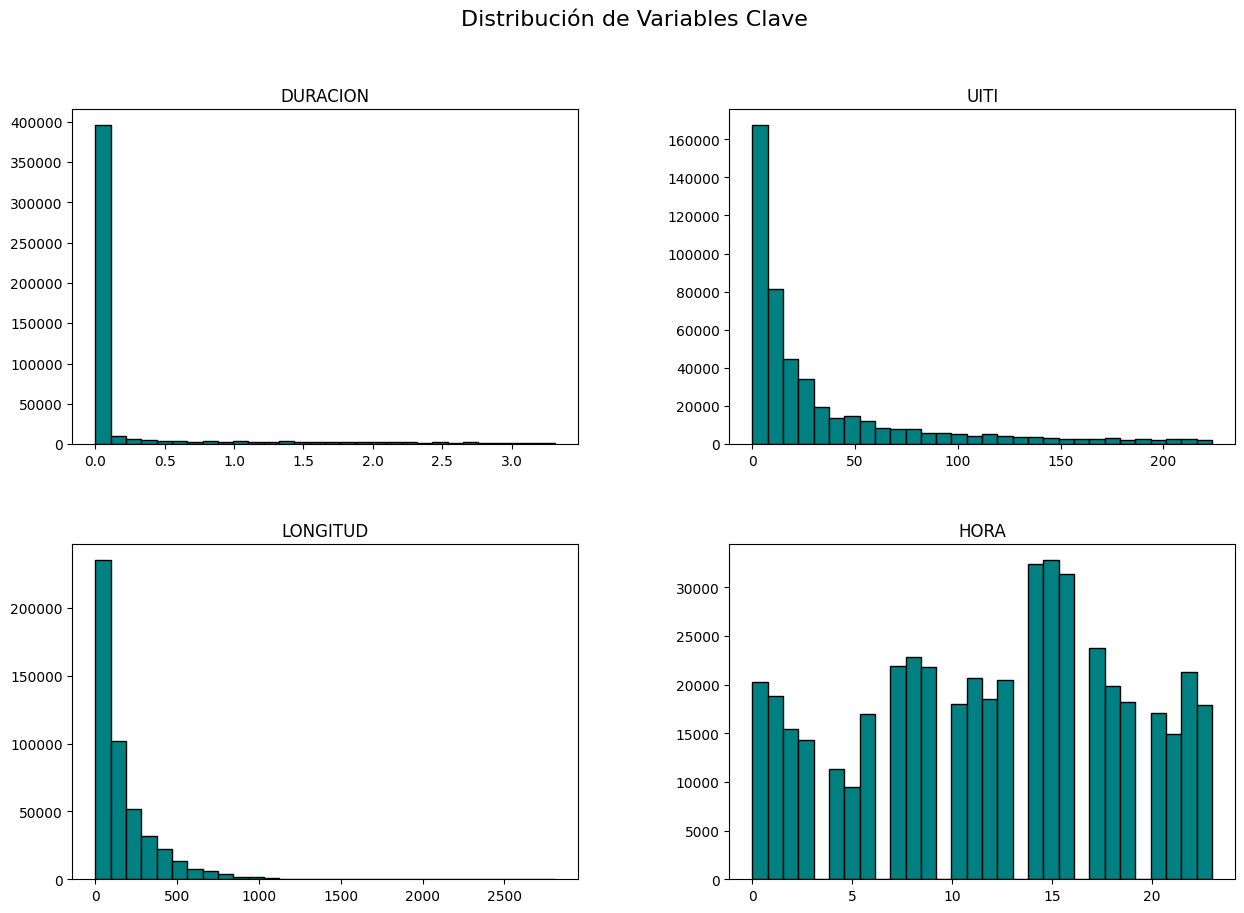

In [17]:


# Seleccionamos solo las columnas numéricas clave para no saturar el gráfico
# Agrega o quita nombres según las columnas que te interesen ver
cols_interes = ['DURACION', 'UITI', 'LONGITUD', 'ALTURA', 'HORA']

# Filtramos el dataframe solo con esas columnas (asegurando que sean numéricas)
subset = df_sin_atipicos[cols_interes].select_dtypes(include=['float64', 'int64', 'int32'])

# Crear los histogramas
subset.hist(bins=30, figsize=(15, 10), color='teal', edgecolor='black', grid=False)

plt.suptitle('Distribución de Variables Clave', fontsize=16)
plt.show()

In [18]:

# 1. Define your columns
cols_corr = ['DURACION', 'UITI', 'LONGITUD', 'ALTURA', 'clouds_15', 'clouds_20', 'HORA']

# 2. Convert these columns to numeric, turning errors into NaNs
for col in cols_corr:
    df_sin_atipicos[col] = pd.to_numeric(df_sin_atipicos[col], errors='coerce')

# 3. Now this will work
corr_subset = df_sin_atipicos[cols_corr].corr()
print(corr_subset)

           DURACION      UITI  LONGITUD    ALTURA  clouds_15  clouds_20  \
DURACION   1.000000  0.315992  0.058508 -0.049782   0.044713  -0.055808   
UITI       0.315992  1.000000 -0.092837  0.017234   0.025594  -0.016350   
LONGITUD   0.058508 -0.092837  1.000000 -0.008351  -0.006206  -0.011438   
ALTURA    -0.049782  0.017234 -0.008351  1.000000  -0.022533  -0.001259   
clouds_15  0.044713  0.025594 -0.006206 -0.022533   1.000000   0.316792   
clouds_20 -0.055808 -0.016350 -0.011438 -0.001259   0.316792   1.000000   
HORA      -0.098035 -0.014116  0.000183  0.006148   0.131360   0.174449   

               HORA  
DURACION  -0.098035  
UITI      -0.014116  
LONGITUD   0.000183  
ALTURA     0.006148  
clouds_15  0.131360  
clouds_20  0.174449  
HORA       1.000000  


In [12]:


# Replace the string 'No encontrado' with an actual missing value object
df_sin_atipicos[cols_corr] = df_sin_atipicos[cols_corr].replace('No encontrado', np.nan)

# Now run correlation
corr_subset = df_sin_atipicos[cols_corr].corr()

In [19]:
# Check data types
print(df_sin_atipicos[cols_corr].dtypes)

# Check specifically for the string in each column
for col in cols_corr:
    if df_sin_atipicos[col].astype(str).str.contains('No encontrado').any():
        print(f"Found 'No encontrado' in column: {col}")

DURACION     float64
UITI         float64
LONGITUD     float64
ALTURA       float64
clouds_15    float64
clouds_20    float64
HORA           int32
dtype: object


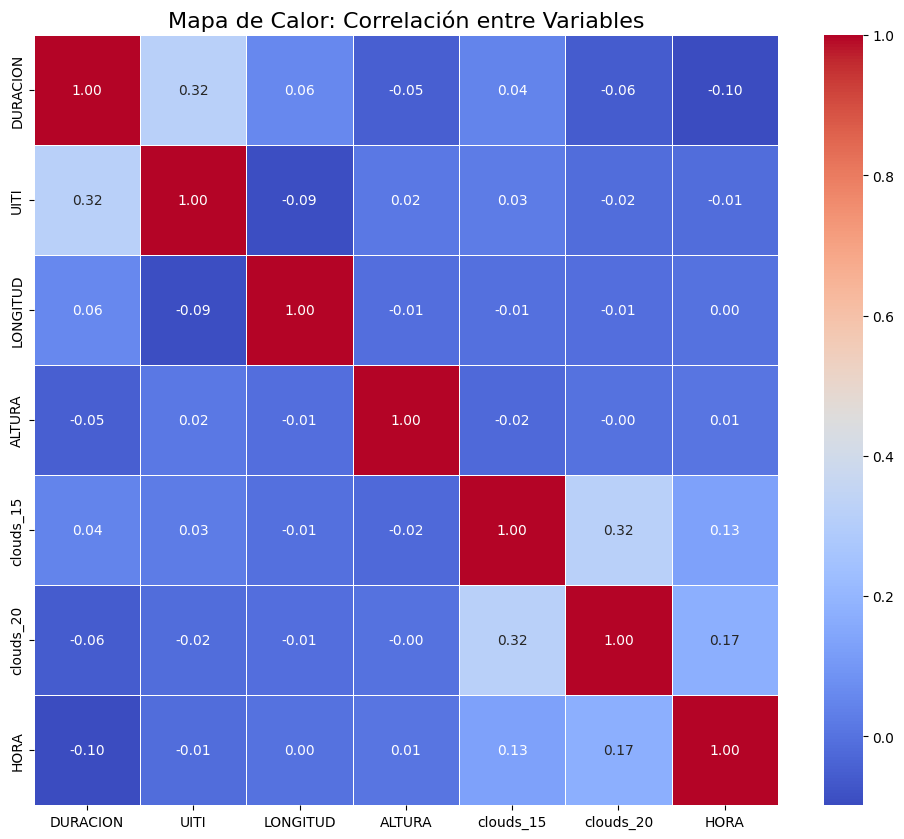

In [20]:
plt.figure(figsize=(12, 10))

# 1. Calcular la matriz de correlación
# Usamos .select_dtypes para evitar errores con columnas de texto
corr_matrix = df_sin_atipicos.select_dtypes(include=['number']).corr()

# 2. Filtrar para ver mejor (Opcional)
# A veces hay demasiadas variables, vamos a ver solo las que tienen correlación fuerte con la DURACION
# o simplemente graficamos un subset pequeño
cols_corr = ['DURACION', 'UITI', 'LONGITUD', 'ALTURA', 'clouds_15', 'clouds_20', 'HORA']
corr_subset = df_sin_atipicos[cols_corr].corr()

# 3. Dibujar el mapa
sns.heatmap(corr_subset, 
            annot=True,       # Muestra el número dentro del cuadro
            cmap='coolwarm',  # Colores: Rojo (caliente) a Azul (frío)
            fmt=".2f",        # 2 decimales
            linewidths=0.5)

plt.title('Mapa de Calor: Correlación entre Variables', fontsize=16)
plt.show()

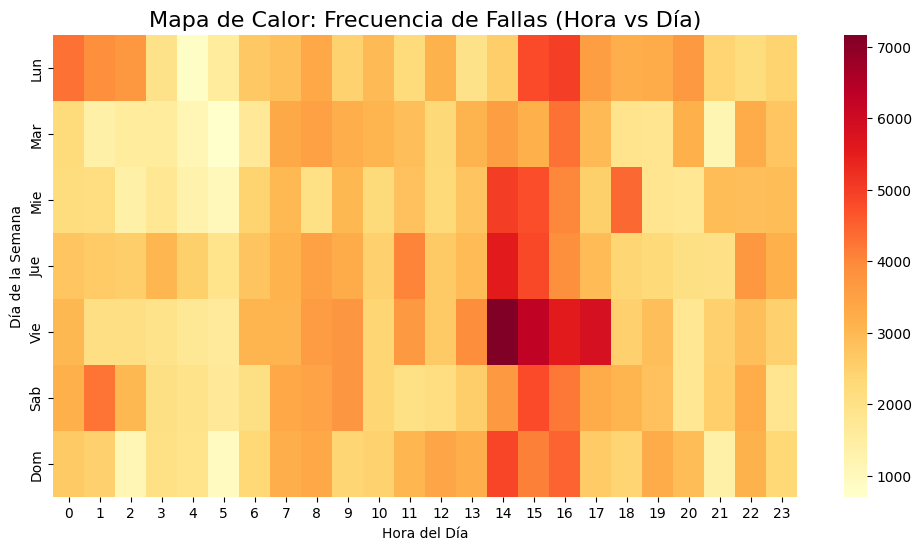

In [25]:
# Crear una tabla dinámica: Filas=Días, Columnas=Horas, Valores=Cantidad de fallas
heatmap_data = pd.crosstab(df_sin_atipicos['DIA_SEMANA'], df['HORA'])

# Nombres de los días para que se vea bonito
dias = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
heatmap_data.index = [dias[i] for i in heatmap_data.index]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False) # YlOrRd = Amarillo a Rojo

plt.title('Mapa de Calor: Frecuencia de Fallas (Hora vs Día)', fontsize=16)
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.show()

# entrenamiento con la dataset limpia por tabnet


##################################################
 ENTRENANDO OBJETIVO: DURACION
##################################################
Iniciando entrenamiento con MAE y monitoreo de R2...

Early stopping occurred at epoch 29 with best_epoch = 14 and best_valid_r2 = 0.08409


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--> FINAL DURACION: MAE=0.3192 | R2=0.0951

##################################################
 ENTRENANDO OBJETIVO: UITI
##################################################
Iniciando entrenamiento con MAE y monitoreo de R2...

Early stopping occurred at epoch 26 with best_epoch = 11 and best_valid_r2 = -0.04762


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--> FINAL UITI: MAE=49.8364 | R2=-0.0508


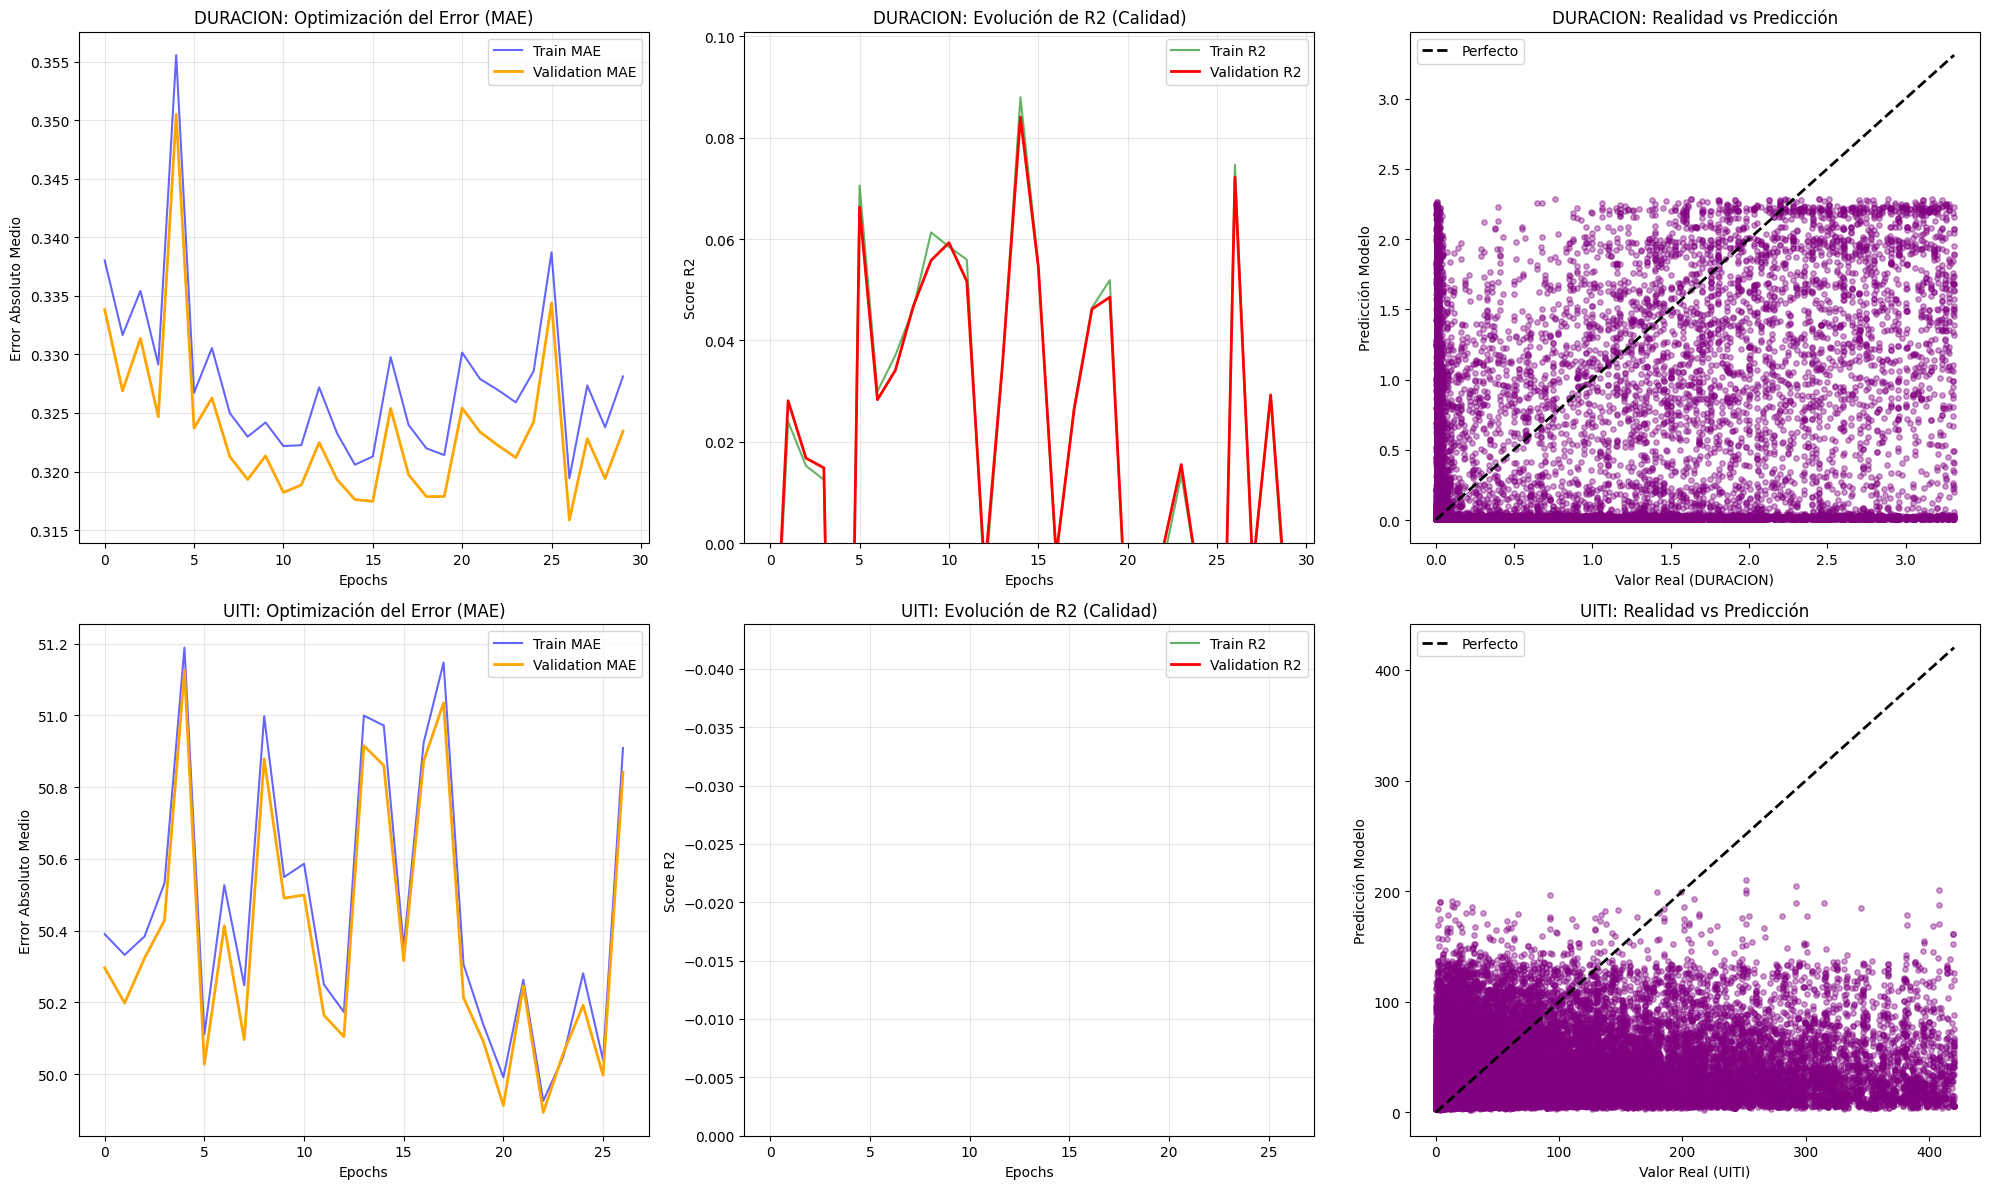

In [28]:


# -------------------------------------------------------------------------
# 1. DEFINICIÓN DE MÉTRICA PERSONALIZADA (R2) PARA TABNET
# -------------------------------------------------------------------------
class R2Metric(Metric):
    """
    Clase personalizada para que TabNet calcule y monitoree R2 en cada época.
    """
    def __init__(self):
        self._name = "r2"
        self._maximize = True # Queremos MAXIMIZAR el R2

    def __call__(self, y_true, y_score):
        # Evitamos errores si el batch es muy pequeño o constante
        if len(y_true) < 2: return 0
        return r2_score(y_true, y_score)

# -------------------------------------------------------------------------
# 2. CONFIGURACIÓN Y LIMPIEZA
# -------------------------------------------------------------------------
targets_list = ['DURACION', 'UITI']

features_tecnicas = [
    'LONGITUD', 'ALTURA', 'NFASES', 'TRAFO', 
    'ENERG_CIRCULA', 'CANTIDAD_TIERRA', 
    'HORA', 'MES', 'DIA_SEMANA'
]

def limpiar_datos_iqr(df, target, features):
    data = df.copy()
    cols = features + [target]
    
    # Numérico
    for col in cols:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna(subset=cols)
    
    # Outliers (IQR)
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[target] >= (Q1 - 1.5 * IQR)) & (data[target] <= (Q3 + 1.5 * IQR))]
    
    return data

# -------------------------------------------------------------------------
# 3. ENTRENAMIENTO ITERATIVO (MAE + MONITOR R2)
# -------------------------------------------------------------------------
# Preparamos 3 columnas de gráficos: MAE, R2 y Predicciones
fig, axs = plt.subplots(len(targets_list), 3, figsize=(20, 6 * len(targets_list)))

for i, target_col in enumerate(targets_list):
    print(f"\n{'#'*50}")
    print(f" ENTRENANDO OBJETIVO: {target_col}")
    print(f"{'#'*50}")
    
    # A. Datos
    df_clean = limpiar_datos_iqr(df, target_col, features_tecnicas)
    X = df_clean[features_tecnicas].values
    y = df_clean[target_col].values.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
    # B. Modelo Configurado para MAE
    # Usamos L1Loss (Mean Absolute Error) como función de optimización
    clf = TabNetRegressor(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax', # 'sparsemax' o 'entmax'
        seed=42,
        verbose=0
    )
    
    print(f"Iniciando entrenamiento con MAE y monitoreo de R2...")
    
    # C. Fit con métricas personalizadas
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['mae', R2Metric], # <--- AQUÍ AGREGAMOS EL R2 PARA MONITOREAR
        loss_fn=torch.nn.L1Loss(),     # <--- AQUÍ FORZAMOS LA OPTIMIZACIÓN POR MAE
        max_epochs=100,
        patience=15,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    # D. Predicciones Finales
    preds = clf.predict(X_test)
    final_mae = mean_absolute_error(y_test, preds)
    final_r2 = r2_score(y_test, preds)
    
    print(f"--> FINAL {target_col}: MAE={final_mae:.4f} | R2={final_r2:.4f}")

    # ----------------------- VISUALIZACIONES -----------------------
    
    # GRÁFICA 1: Evolución del MAE (Loss)
    axs[i, 0].plot(clf.history['train_mae'], label='Train MAE', color='blue', alpha=0.6)
    axs[i, 0].plot(clf.history['valid_mae'], label='Validation MAE', color='orange', linewidth=2)
    axs[i, 0].set_title(f'{target_col}: Optimización del Error (MAE)')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Error Absoluto Medio')
    axs[i, 0].legend()
    axs[i, 0].grid(True, alpha=0.3)
    
    # GRÁFICA 2: Evolución del R2 (La línea que pediste)
    axs[i, 1].plot(clf.history['train_r2'], label='Train R2', color='green', alpha=0.6)
    axs[i, 1].plot(clf.history['valid_r2'], label='Validation R2', color='red', linewidth=2)
    axs[i, 1].set_title(f'{target_col}: Evolución de R2 (Calidad)')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Score R2')
    axs[i, 1].set_ylim(bottom=0) # Fijamos el piso en 0 para ver mejor la mejora
    axs[i, 1].legend()
    axs[i, 1].grid(True, alpha=0.3)
    
    # GRÁFICA 3: Real vs Predicho
    axs[i, 2].scatter(y_test, preds, alpha=0.4, c='purple', s=15)
    
    # Línea de perfección
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    axs[i, 2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfecto')
    
    axs[i, 2].set_title(f'{target_col}: Realidad vs Predicción')
    axs[i, 2].set_xlabel(f'Valor Real ({target_col})')
    axs[i, 2].set_ylabel('Predicción Modelo')
    axs[i, 2].legend()

plt.tight_layout()
plt.show()

In [18]:
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvi

# prueba con variables meteorologicas integradas


Total features: 234

--- PROCESANDO: DURACION ---
Entrenando...
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_r2 = 0.40436


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--> DURACION: MAE=0.2310 | R2=0.4198

--- PROCESANDO: UITI ---
Entrenando...

Early stopping occurred at epoch 99 with best_epoch = 84 and best_valid_r2 = 0.35521


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--> UITI: MAE=35.0006 | R2=0.3437


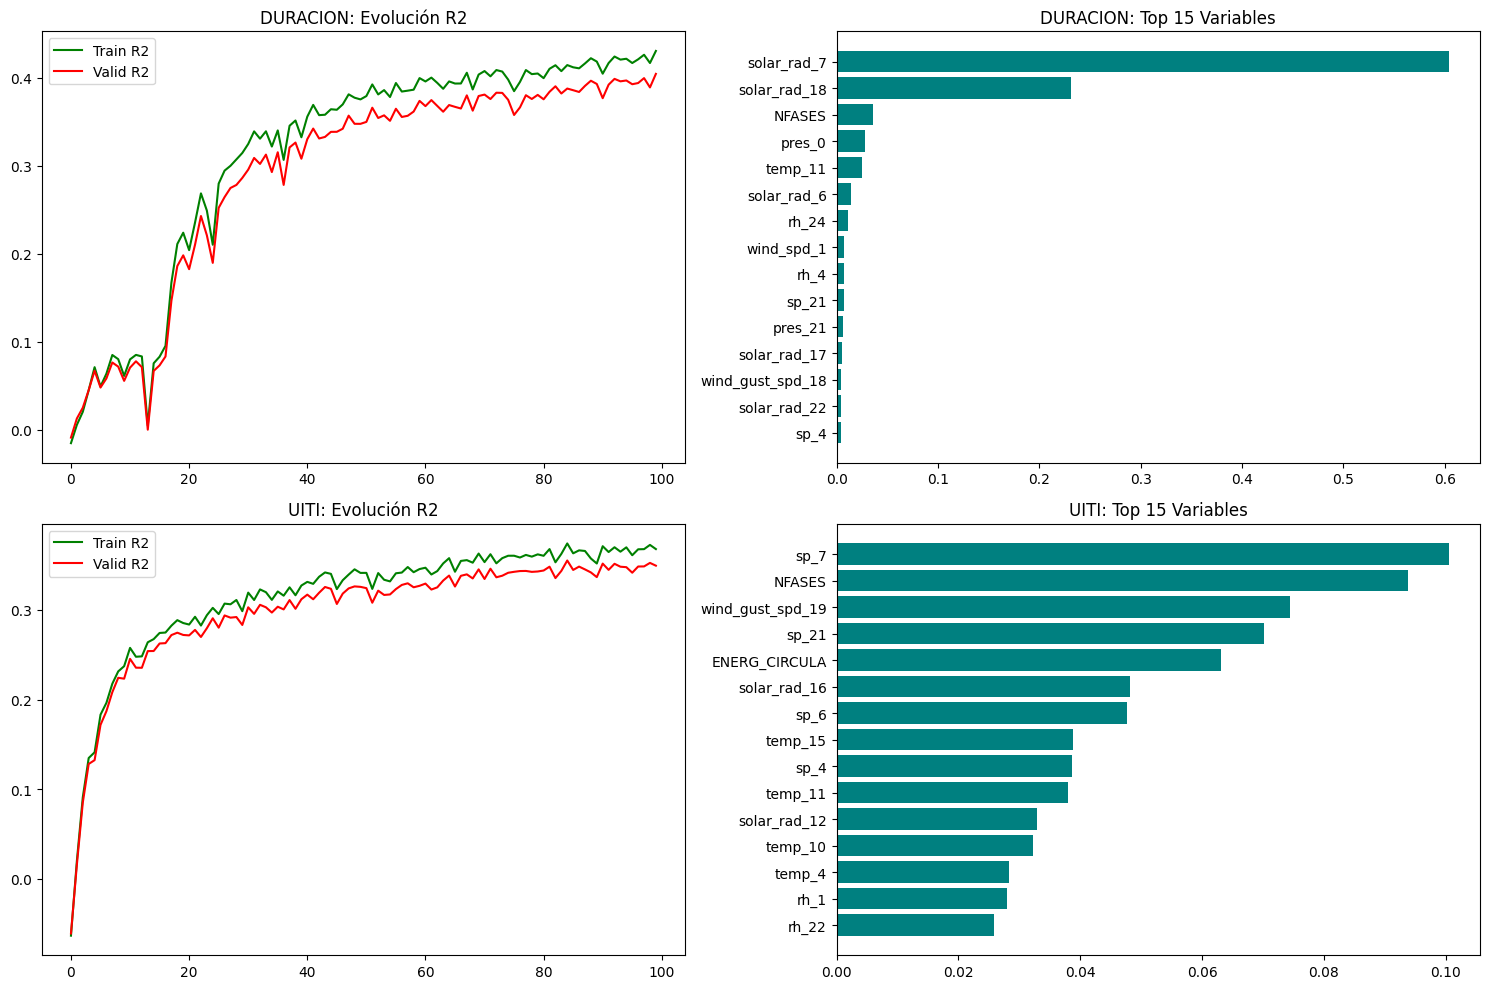

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc # <--- Importante: Garbage Collector para liberar memoria RAM
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# -------------------------------------------------------------------------
# 1. MÉTRICA
# -------------------------------------------------------------------------
class R2Metric(Metric):
    def __init__(self):
        self._name = "r2"
        self._maximize = True
    def __call__(self, y_true, y_score):
        if len(y_true) < 2: return 0
        return r2_score(y_true, y_score)

# -------------------------------------------------------------------------
# 2. DEFINICIÓN DE VARIABLES
# -------------------------------------------------------------------------
cols_tecnicas = [
    'LONGITUD', 'ALTURA', 'NFASES', 'TRAFO', 
    'ENERG_CIRCULA', 'CANTIDAD_TIERRA', 
    'HORA', 'MES', 'DIA_SEMANA'
]

prefijos_clima = ['temp', 'prep', 'rh', 'wind', 'clouds', 'solar_rad', 'pres', 'sp']
cols_clima = [col for col in df.columns if any(col.startswith(p) for p in prefijos_clima)]
features_totales = cols_tecnicas + cols_clima

print(f"Total features: {len(features_totales)}")

# -------------------------------------------------------------------------
# 3. LIMPIEZA OPTIMIZADA PARA MEMORIA (FLOAT32)
# -------------------------------------------------------------------------
def limpiar_y_optimizar(df, target, features):
    # Seleccionamos solo lo necesario para no copiar todo el dataset
    cols = features + [target]
    data = df[cols].copy()
    
    # Optimización agresiva de memoria
    for col in data.columns:
        # Convertimos a numérico y bajamos a float32 inmediatamente
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('float32')
    
    data = data.dropna()
    
    # IQR Outliers
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[target] >= (Q1 - 1.5 * IQR)) & (data[target] <= (Q3 + 1.5 * IQR))]
    
    return data

# -------------------------------------------------------------------------
# 4. ENTRENAMIENTO CON GESTIÓN DE MEMORIA
# -------------------------------------------------------------------------
targets_list = ['DURACION', 'UITI']

# Reducimos figsize para no gastar RAM en gráficos gigantes si no es necesario
fig, axs = plt.subplots(len(targets_list), 2, figsize=(15, 5 * len(targets_list))) 
# Nota: Reduje a 2 columnas de gráficos para simplificar visualización

for i, target_col in enumerate(targets_list):
    print(f"\n--- PROCESANDO: {target_col} ---")
    
    # A. Limpieza
    df_clean = limpiar_y_optimizar(df, target_col, features_totales)
    
    # B. Extraer valores y BORRAR dataframe inmediatamente
    X = df_clean[features_totales].values # Ya está en float32
    y = df_clean[target_col].values.reshape(-1, 1)
    
    del df_clean # <--- BORRAMOS EL DF DE MEMORIA
    gc.collect() # <--- FORZAMOS LIMPIEZA DE RAM
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
    # Borramos X e y grandes, nos quedamos solo con los splits
    del X, y
    gc.collect()
    
    # C. Configuración TabNet "Lightweight"
    clf = TabNetRegressor(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":10, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax',
        seed=42,
        verbose=0
    )
    
    print("Entrenando...")
    
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['mae', R2Metric],
        loss_fn=torch.nn.L1Loss(),
        max_epochs=100,      # Bajamos un poco para asegurar que termine
        patience=15,
        batch_size=512,      # <--- REDUCIDO A LA MITAD (Antes 1024) para evitar OOM
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False
    )
    
    # D. Métricas
    preds = clf.predict(X_test)
    final_mae = mean_absolute_error(y_test, preds)
    final_r2 = r2_score(y_test, preds)
    print(f"--> {target_col}: MAE={final_mae:.4f} | R2={final_r2:.4f}")
    
    # E. Visualización (Simplificada)
    # Gráfica 1: Evolución R2
    axs[i, 0].plot(clf.history['train_r2'], label='Train R2', color='green')
    axs[i, 0].plot(clf.history['valid_r2'], label='Valid R2', color='red')
    axs[i, 0].set_title(f'{target_col}: Evolución R2')
    axs[i, 0].legend()
    
    # Gráfica 2: Top 15 Feature Importance
    feat_importances = clf.feature_importances_
    indices = np.argsort(feat_importances)[-15:] # Top 15
    axs[i, 1].barh(range(len(indices)), feat_importances[indices], align='center', color='teal')
    axs[i, 1].set_yticks(range(len(indices)))
    axs[i, 1].set_yticklabels([features_totales[j] for j in indices])
    axs[i, 1].set_title(f'{target_col}: Top 15 Variables')
    
    # Limpieza final de iteración
    del clf, X_train, X_test, y_train, y_test, preds
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    gc.collect()

plt.tight_layout()
plt.show()

## Test 1


 PROCESANDO TARGET: DURACION
[DURACION] Datos originales: 659058 -> Tras limpieza: 560673
Entrenando TabNet (puede tardar un poco)...

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_rmse = 0.64206


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Resultado Final -> R2: 0.2492 | RMSE: 0.6460

 PROCESANDO TARGET: UITI
[UITI] Datos originales: 659058 -> Tras limpieza: 561165
Entrenando TabNet (puede tardar un poco)...

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_rmse = 83.50547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Resultado Final -> R2: 0.1218 | RMSE: 82.9772


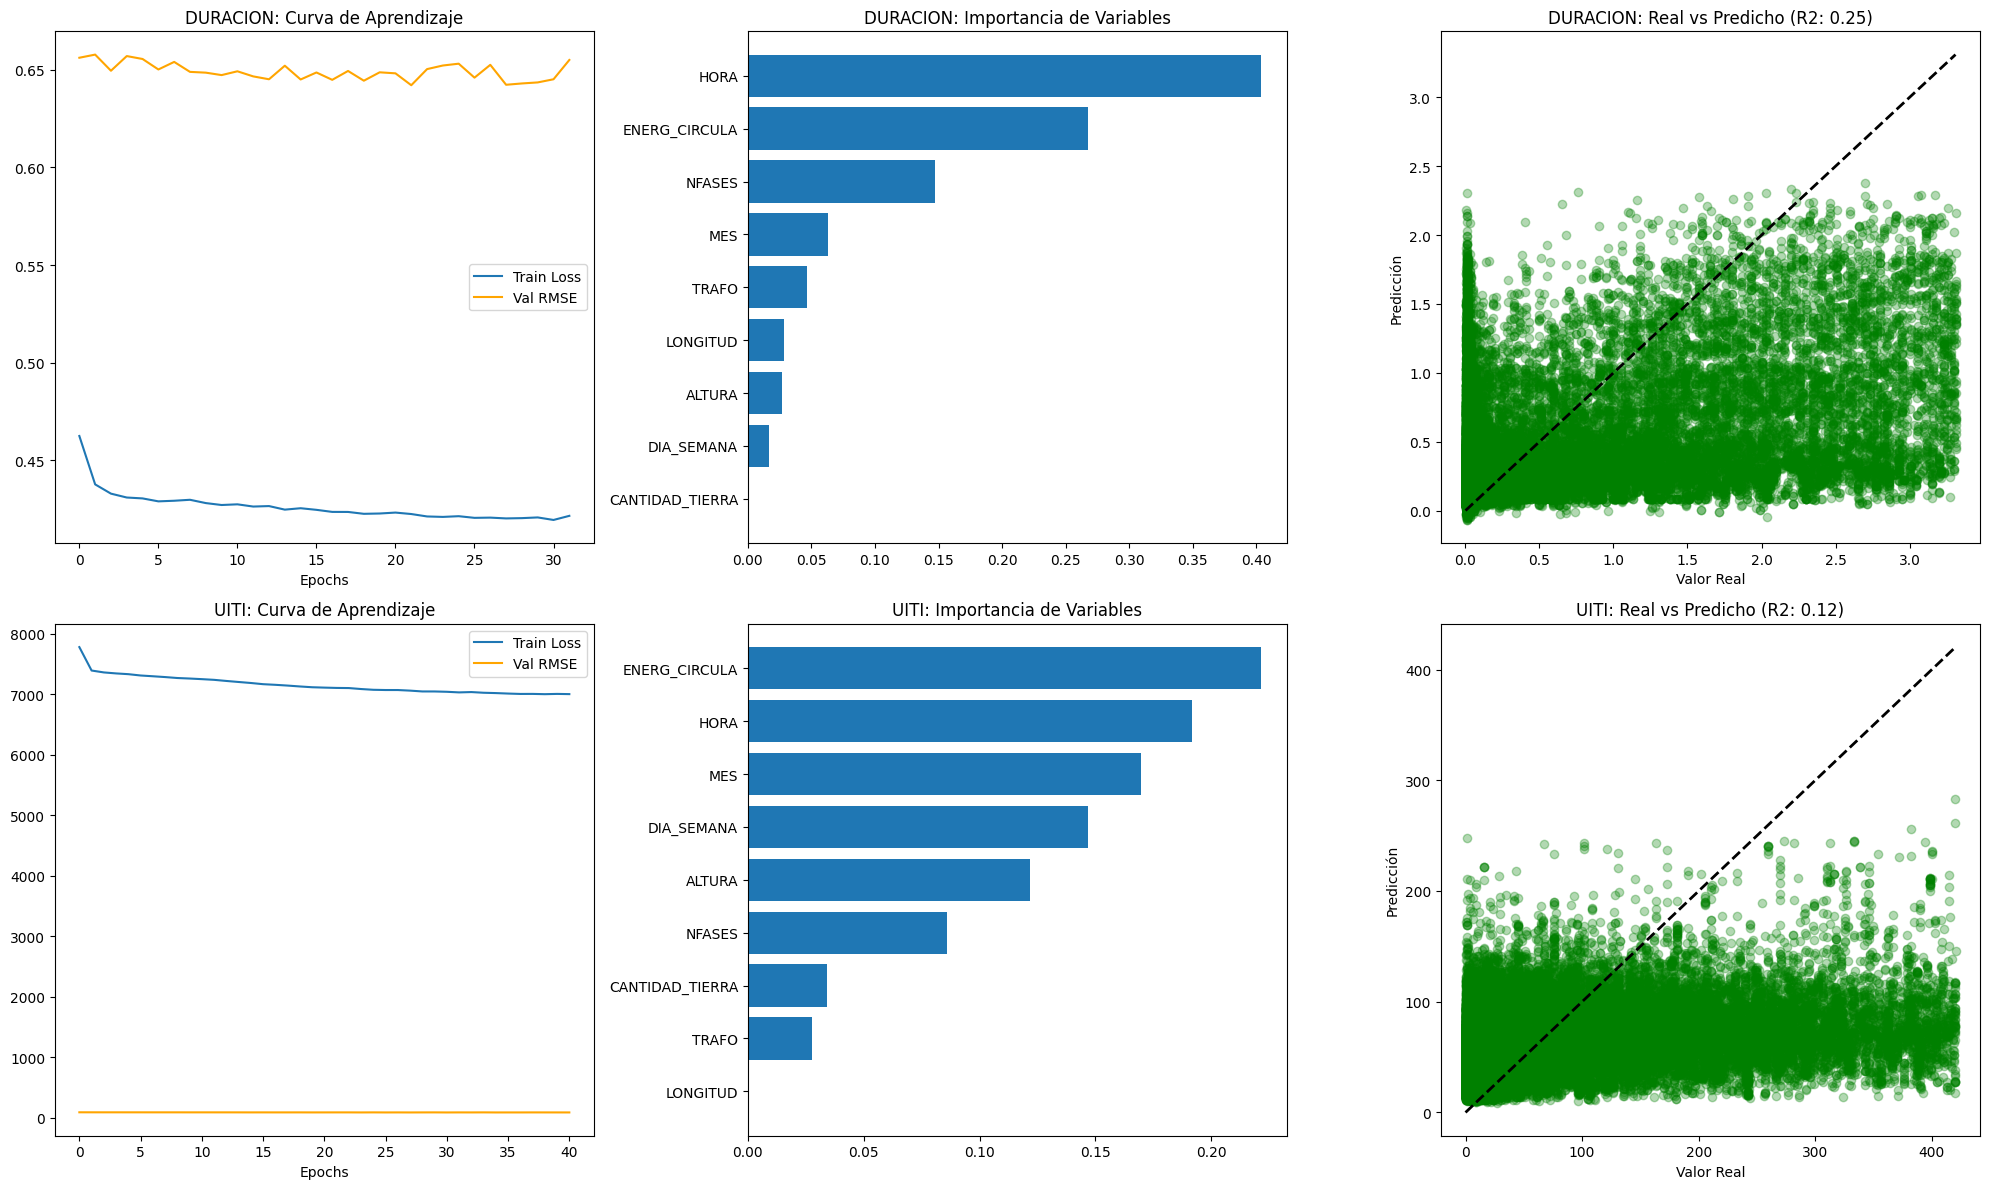

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# -------------------------------------------------------------------------
# 1. CONFIGURACIÓN
# -------------------------------------------------------------------------
targets_list = ['DURACION', 'UITI']

features_tecnicas = [
    'LONGITUD', 'ALTURA', 'NFASES', 'TRAFO', 
    'ENERG_CIRCULA', 'CANTIDAD_TIERRA', 
    'HORA', 'MES', 'DIA_SEMANA'
]

# -------------------------------------------------------------------------
# 2. FUNCIÓN DE LIMPIEZA (Atípicos + Nulos)
# -------------------------------------------------------------------------
def preparar_datos(df, target, features):
    data = df.copy()
    
    # a. Convertir a numérico
    cols = features + [target]
    for col in cols:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # b. Eliminar nulos
    data = data.dropna(subset=cols)
    
    # c. Eliminar Outliers (Método IQR)
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    data_clean = data[(data[target] >= lower) & (data[target] <= upper)].copy()
    print(f"[{target}] Datos originales: {len(df)} -> Tras limpieza: {len(data_clean)}")
    
    return data_clean

# -------------------------------------------------------------------------
# 3. BUCLE DE ENTRENAMIENTO Y VISUALIZACIÓN
# -------------------------------------------------------------------------
fig, axs = plt.subplots(len(targets_list), 3, figsize=(20, 6 * len(targets_list)))

for i, target_col in enumerate(targets_list):
    print(f"\n{'='*40}")
    print(f" PROCESANDO TARGET: {target_col}")
    print(f"{'='*40}")
    
    # A. Preparar X e y
    df_clean = preparar_datos(df, target_col, features_tecnicas)
    
    X = df_clean[features_tecnicas].values # TabNet necesita numpy arrays
    y = df_clean[target_col].values.reshape(-1, 1) # Target debe ser 2D (N, 1)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    
    # B. Configurar TabNet
    # Puedes ajustar 'n_d' y 'n_a' (dimensiones de atención) para más complejidad
    clf = TabNetRegressor(verbose=0, seed=42)
    
    # C. Entrenar
    print("Entrenando TabNet (puede tardar un poco)...")
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['rmse'],
        max_epochs=100,      # Aumentar si falta convergencia
        patience=10,         # Parar si no mejora en 10 epocas
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    # D. Métricas
    preds = clf.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Resultado Final -> R2: {r2:.4f} | RMSE: {rmse:.4f}")
    
    # ----------------------- VISUALIZACIONES -----------------------
    
    # Gráfica 1: Curva de Pérdida (Loss)
    axs[i, 0].plot(clf.history['loss'], label='Train Loss')
    axs[i, 0].plot(clf.history['valid_rmse'], label='Val RMSE', color='orange')
    axs[i, 0].set_title(f'{target_col}: Curva de Aprendizaje')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].legend()
    
    # Gráfica 2: Feature Importance (Lo mejor de TabNet)
    feat_importances = clf.feature_importances_
    indices = np.argsort(feat_importances)
    
    axs[i, 1].barh(range(len(indices)), feat_importances[indices], align='center')
    axs[i, 1].set_yticks(range(len(indices)))
    axs[i, 1].set_yticklabels([features_tecnicas[j] for j in indices])
    axs[i, 1].set_title(f'{target_col}: Importancia de Variables')
    
    # Gráfica 3: Real vs Predicho
    axs[i, 2].scatter(y_test, preds, alpha=0.3, c='green')
    axs[i, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i, 2].set_xlabel('Valor Real')
    axs[i, 2].set_ylabel('Predicción')
    axs[i, 2].set_title(f'{target_col}: Real vs Predicho (R2: {r2:.2f})')

plt.tight_layout()
plt.show()